**Notebook for training several Autoencoders with different configurations**

# Set Up

In [ ]:
# This is the path to the helper functions folder
# On drive for example: '/content/drive/My Drive/myfolder/helper_functions'
modules_path = './helper_functions'
models_path = './models' # for the models folder

# This is the path to the data folder
# On drive for example: '/content/drive/myfolder/data'
base_path = './data/'

# This is the path to the tensorflow checkpoint folder
# On drive for example: '/content/drive/MyDrive/best_models'
checkpoint_filepath = './best_models'

In [ ]:
# pip calls
!pip install tensorflow_addons

# all the nice imports <3
import os
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import h5py
import numpy as np
from datetime import datetime
import keras
import importlib
import pickle

# black magic, so that tf.Tensor objects can be used as numpy things
# all hail tensorflow 0_0
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# show important library versions
print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)


# add custom paths (to import the nice models and helper classes)
import sys
sys.path.append(models_path)
sys.path.append(modules_path)

# add custom imports here
import processing
import metrics
import autoencoder_models as am

# Very specific Colab things

In [ ]:
# import & mount drive
from google.colab import drive
drive.mount('/content/drive')

# hardware speed-up magic (TPU OR GPU?)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Warning: GPU device not found')
else:  
  print('Found GPU at: {}'.format(device_name))

# Tensorboard stuff (callbacks for logging data)
%load_ext tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Compile different contrast ratio data sets into one

In [ ]:
# COMPLIE DIFFERENT DS INTO ONE
# n=16_x=10000_cr=0.0020_DS.h5
dataset_size = '1000'
size = '64' # or 32 or 64

cr = np.array(['0.1000', '0.0500', '0.0200', '0.0100', '0.0050', '0.0020'])

size_path = size + 'x' + size + '/'
paths = []
tp_paths = []

images = []
labels = []

for i in range(0, cr.shape[0]):
  paths.append(base_path + size_path + 'n=' + size + '_x=' + dataset_size + '_cr=' + cr[i] + '_DS.h5')
  tp_paths.append(base_path + size_path + 'n=' + size + '_x=' + dataset_size + '_cr=' + cr[i] + '_TP.h5')

  f = h5py.File(paths[i], 'r')
  tp_f = h5py.File(tp_paths[i], 'r')

  imgs = np.array(f['images'])
  labs = np.array(f['c_vectors'])
  tp_imgs = np.array(tp_f['twopoint'])

  f.close()

  if len(images) == 0:
    images = imgs
    labels = labs
    tp_images = tp_imgs
  else:
    images = np.append(images, imgs, axis=0)
    labels = np.append(labels, labs, axis=0)

    tp_images = np.append(tp_images, tp_imgs, axis=0)

  

print("Created image array of shape: ", images.shape)
print("Created label array of shape: ", labels.shape)
print("Created TP image array of shape: ", tp_images.shape)

Created image array of shape:  (6000, 4096)
Created label array of shape:  (6000, 9)
Created TP image array of shape:  (6000, 4096)


# Old set up code
Compile or get two-point correlation images, by computing 2-point correlations

In [ ]:
RECOMPUTE_TP = False
if RECOMPUTE_TP:

  importlib.reload(processing)
  dataproc = processing.Processing(
      images, 
      labels, 
      np.array([0.8, 0.1, 0.1]), 
      batch_size=256, 
      conv_behavior=True, 
      scale_labels=False, 
      symmetric=True, 
      twopoint=True,
      shuffle=False,
      pca=False,
      # pca_variance=0.7
      )

  tp_images = dataproc.images

  f = h5py.File(base_path+size_path+'imgs_twopoint_'+size+'.h5', 'w')
  f.create_dataset('twopoint', data=tp_images)
  f.close()

else:
  f = h5py.File(base_path+size_path+'imgs_twopoint_'+size+'.h5', 'r')
  tp_images = np.array(f['twopoint'])

# Set Up of Code
1. Size of test set
1. problem and problem folder
1. size of images

In [ ]:
# 1.
TEST_SIZE = 1000
EPOCHS = 1000

# 2.
PROBLEM = 'AUTO64'
PROBLEM_FOLDER = 'autoencoders'

# 3.
sample_size = 64


size = str(sample_size)
size_path = size + 'x' + size + '/'
model_base_path = './'+ PROBLEM_FOLDER + '/' + size_path

# Execution of Code

In [ ]:
results_array = []
FILENAME = 'all_data_' + PROBLEM
SPLITS = np.array([0.9, 0.1, 0])

counter = 0

ds_size_array = [5000]
twopoint_array = [False]


for ds in ds_size_array:
  for tp in twopoint_array:

    counter += 1
    print("Currently working on model No.", counter)

    imgs = images
    labs = labels
    if tp:
      imgs = tp_images
    
    print(imgs.shape)

    dataproc = processing.Processing(
      imgs[:ds], 
      labs[:ds], 
      SPLITS, 
      custom_test = (imgs[-TEST_SIZE:], labs[-TEST_SIZE:]),
      batch_size=256, 
      conv_behavior=True, 
      scale_labels=False, 
      symmetric=True, 
      twopoint=False,
      shuffle=False,
      pca=False,
      # pca_variance=0.7
      )
    print(dataproc.splits[0])
    
    encoder = am.create_enc_spec(inputshape=(sample_size,sample_size,1))
    decoder = am.create_dec_spec(inputshape=(8,8,4))
    autoencoder = am.ConvAuto(encoder, decoder)
    print(autoencoder.summary())

    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_r_square',
        mode='max',
        save_best_only=True)


    train_data, val_data, test_data = dataproc.datasets_auto

    params = {
        'x' : train_data,
        'batch_size' : dataproc.batch_size, 
        'epochs' : EPOCHS, 
        'validation_data' : val_data,
        'verbose' : 1, 
        'callbacks' : [tensorboard_callback, model_checkpoint_callback]
    }

    autoencoder.compile(optimizer="Adam", loss="mse", metrics=tfa.metrics.RSquare())
    history = autoencoder.fit(**params)

    autoencoder.load_weights(checkpoint_filepath)

    test_metrics = autoencoder.evaluate(test_data)

    custom_path = PROBLEM + '_ds' + str(dataproc.splits[0]) + '_tp' + str(tp) + '_epochs' + str(params['epochs'])
    total_path = model_base_path + custom_path
    encoder.save(total_path)


    results_array.append(
        {
            'run_name' : custom_path,
            'model_name' : 'autoencoder',
            'regularization' : 0,
            'ds_size' : dataproc.splits[0],
            'twopoint' : tp,
            'contrast_ratio' : cr,
            'epochs' : params['epochs'],
            'history' : history.history,
            'test_metrics' : test_metrics,
            'model_function' : am.ConvAuto,
            'path_to_weights' : total_path,
        }
    )


with open(model_base_path + 'history/' + FILENAME, 'wb') as file_pi:
  pickle.dump(results_array, file_pi)

In [ ]:
%tensorboard --logdir logs/scalars

# Example of reconstruction evaluation

(1, 32, 32, 1)


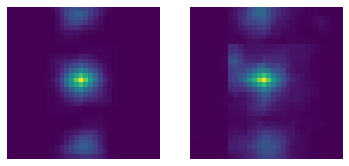

In [ ]:
index = 0
original = imgs[index].reshape(1,32,32,1)

pred = autoencoder(original)

plt.subplot(1,2,1)
plt.imshow(np.squeeze(original))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.squeeze(pred))
plt.axis('off')

plt.savefig('./autoencoder32_pred2pc'+str(index), pad_inches=0, dpi=200)